# Implementing a Transformer Model from Scratch

This tutorial walks through an implementation of the Transformer model components as described in the original paper "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" by Vaswani et al.

## Overview
The code below defines the essential building blocks of the Transformer architecture:

- **Feed-Forward Networks**
- **Multi-Head Attention**
- **Positional Encodings**
- **Encoder and Decoder layers**
- **The full Transformer model**

We will also explain the underlying concepts such as masking, scaling factors, and the role of positional encodings.

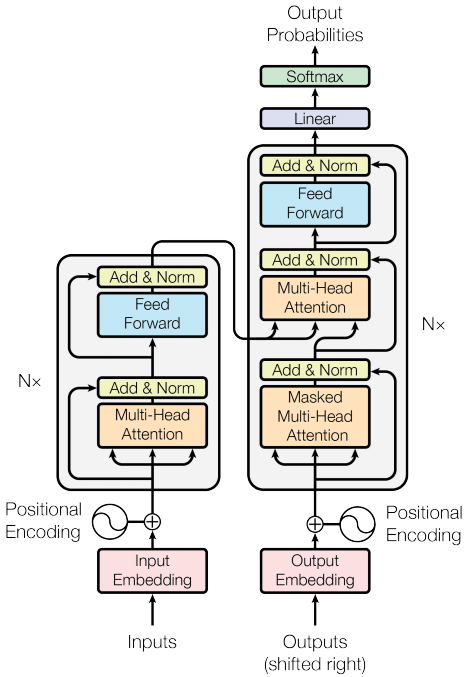
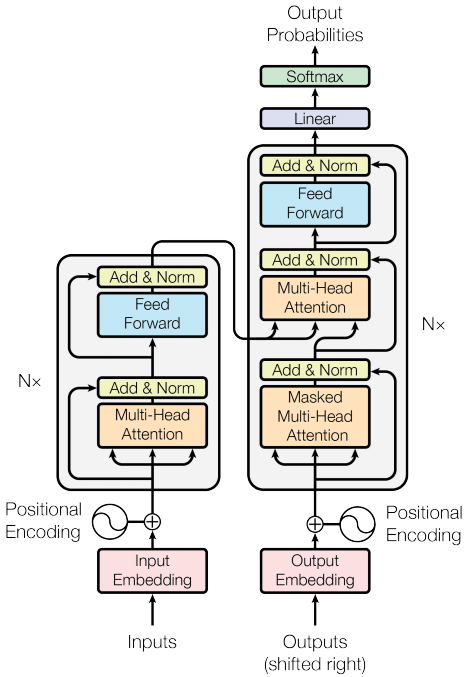

In [3]:
import math
import torch
import numpy as np


## Softmax Implementation
We'll start by defining a helper `softmax` function. Though PyTorch provides F.softmax, having a small wrapper can make the code more self-documenting.



In [4]:
def softmax(x: torch.Tensor, d: int):
    # return torch.nn.Softmax(dim=d)(x)
    return torch.nn.functional.softmax(x, dim=d)

## Feed-Forward Network

The Feed-Forward (FFN) layer is applied after the multi-head attention in both the encoder and the decoder. It consists of two linear transformations with a non-linear activation in between. According to the original paper, the inner dimension is often much larger than `d_model` (e.g., 2048 when `d_model` is 512).

### Key Points:
- Input and output dimensions match `d_model`.
- Hidden dimension(s) can be configured; by default, we use a two-layer FFN with dimensions `(d_model, 2048)` and `(2048, d_model)`.
- A typical activation is `ReLU`.


In [5]:
class FeedForward(torch.nn.Module):
    def __init__(
        self,
        d_model: int = 512,
        hidden_size: list[tuple[int]] = None,
        activation: torch.nn.Module = torch.nn.ReLU(),
    ):
        """
        notes:
            - default dimensions are set according to paper

        """
        if hidden_size is None:
            hidden_size = [(d_model, 2048), (2048, d_model)]

        assert len(hidden_size) > 0, "hidden_size must be greater than 0"
        assert (
            hidden_size[0][0] == d_model and hidden_size[-1][1] == d_model
        ), "input and output dimensions must equal d_model"

        super().__init__()

        layers = []
        n = len(hidden_size)
        for i in range(n):
            layers.append(torch.nn.Linear(*hidden_size[i]))

            # No activation after the final layer
            if i < n - 1:
                layers.append(activation)

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)


## Attention Mechanisms and Transformers¶

The central concept of the Transformer model is the **attention mechanism**, initially introduced as an improvement for encoder-decoder RNNs in sequence-to-sequence tasks like machine translation (Bahdanau et al., 2014). Early sequence-to-sequence models for machine translation (Sutskever et al., 2014) relied on encoding the entire input into a single fixed-length vector, which was then passed to the decoder. However, the attention mechanism shifted this paradigm by allowing the decoder to revisit and focus on specific parts of the input sequence at every decoding step.

### Key Intuition Behind Attention
Rather than compressing the input into a single representation, attention enables the decoder to dynamically focus on different parts of the input sequence at each step. Bahdanau’s attention mechanism achieved this by allowing the encoder to generate a sequence of representations (equal in length to the input). At each decoding step, the decoder uses a weighted sum of these representations as its context vector. These weights, which indicate how much focus is placed on each input token, are learned as part of the model through differentiable optimization. This innovation significantly improved the performance of RNN-based architectures for machine translation.

### Attention's Early Impact and Interpretability
Attention mechanisms quickly became a successful enhancement for RNNs, outperforming traditional sequence-to-sequence architectures. They also offered qualitative insights: by inspecting attention weights, researchers noticed that high weights often corresponded to meaningful cross-lingual relationships. For instance, in translating “my feet hurt” to “j’ai mal au pieds,” the model might assign high attention weights to the word “feet” when generating “pieds.” This led to claims that attention mechanisms provided a degree of “interpretability,” though the precise meaning of these weights remains a topic of research.

### The Rise of Transformers
Beyond their role in improving RNNs, attention mechanisms proved to be a foundational idea for entirely new architectures. Vaswani et al. (2017) introduced the **Transformer**, which eliminated recurrent connections entirely, instead using attention to model relationships between input and output tokens. This architecture achieved state-of-the-art results in machine translation and rapidly gained prominence in NLP.

By 2018, Transformers dominated the field of natural language processing. Simultaneously, the trend of pretraining large models on massive generic datasets, followed by fine-tuning on specific downstream tasks, became standard practice. Transformers excelled in this paradigm, outperforming traditional architectures by a wide margin. This shift coincided with the emergence of large-scale pretrained models, now often referred to as **foundation models** (Bommasani et al., 2021).


## Scaled Dot Product Attention

The foundation of self-attention lies in the **scaled dot product attention** mechanism. The goal is to enable any element in a sequence to attend to other elements efficiently. This mechanism uses a set of queries:

$$
Q \in \mathbb{R}^{T \times d_k},
$$

keys:

$$
K \in \mathbb{R}^{T \times d_k},
$$

and values:

$$
V \in \mathbb{R}^{T \times d_v},
$$

where $ T $ is the sequence length, and $ d_k $ and $ d_v $ represent the hidden dimensions for queries/keys and values, respectively. For simplicity, the batch dimension is omitted here. The attention score between elements $ i $ and $ j $ is computed based on the similarity between query $ Q_i $ and key $ K_j $, with the dot product serving as the similarity measure. Mathematically, this is expressed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

The matrix multiplication:

$$
QK^\top
$$

calculates the dot product for every pair of queries and keys, resulting in a:

$$
T \times T
$$

matrix of attention logits. Each row represents how much a specific element $i$ should focus on every other element in the sequence. A softmax function is applied to these logits, producing attention weights. These weights are then used to compute a weighted sum of the values, resulting in the final output. This approach ensures that the mechanism dynamically attends to different parts of the sequence.

For a deeper understanding, this process can also be visualized as a computation graph (figure credit - Vaswani et al., 2017).

![Multihead Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/scaled_dot_product_attn.svg)

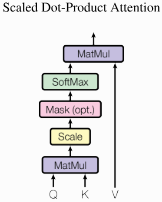
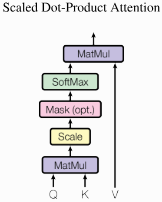
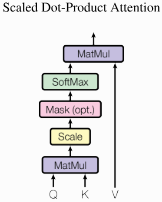
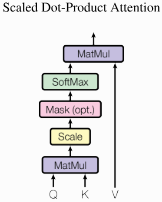

### In our code:
- **Q** (Query), **K** (Key), **V** (Value) are projected versions of the input embeddings.
- We apply masking to ensure that the model does not attend to padded tokens or, in the decoder, future tokens.
- Masking uses `-inf` values so that `softmax` ignores those positions.


In [6]:
def attention(
    q: torch.Tensor,
    k: torch.Tensor,
    v: torch.Tensor,
    pad_mask: torch.Tensor,
    mask: torch.Tensor = None,
):
    """
    input:
        q: a torch tensor of size: (batch_size*h, seq_len, d_k)
        k: a torch tensor of size: (batch_size*h, seq_len, d_k)
        v: a torch tensor of size: (batch_size*h, seq_len, d_v)
        pad_mask: a torch tensor of size: (batch_size*h, seq_len, seq_len)
        mask: a torch tensor of size: (seq_len, seq_len)

    output:
        A torch tensor of size: (batch_size*h, seq_len, d_v)

    """
    x = torch.matmul(q, torch.transpose(k, 1, 2))

    # Scale x by sqrt(d_k)
    x = x / math.sqrt(q.size(2))

    if mask is not None:

        # Broadcasting will match the size at dim=0
        mask = mask.unsqueeze(0)

        # Apply mask via element-wise addition
        x = x + mask

    x = x + pad_mask

    return torch.matmul(softmax(x, d=2), v)

## Multi-Head Attention

The **Multi-Head Attention (MHA)** layer projects the input embeddings into multiple smaller embedding subspaces (heads), applies the attention function in parallel, and then concatenates the results. This allows the model to focus on different positions from different representation subspaces.

### Key Points:
- We split the input `(batch_size, seq_len, d_model)` into `h` heads `(batch_size, h, seq_len, d_k)`.

- The relationship between ` d_k` and `d_model` is given as:

  $$
  d_k = \frac{d_\text{model}}{h}.
  $$

- After applying attention, we concatenate the heads and apply a final linear transformation.


<br>
<br>
<br>
<br>

![Multihead Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/multihead_attention.svg)

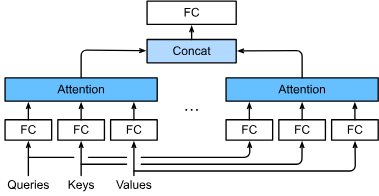
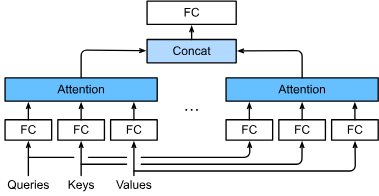
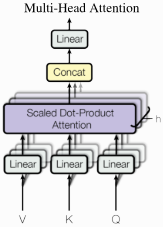
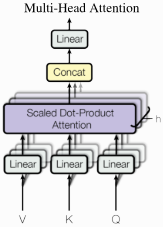

In [7]:
class MultiHead(torch.nn.Module):
    def __init__(self, h: int = 8, d_model: int = 512, mask: torch.Tensor = None):
        """
        input:
            h: number of heads
            d_model: model dimensions, i.e. embedding size
            mask: a boolean to apply masked multi-head attention
        notes:
            - default dimensions are set according to the paper

        """
        assert d_model % h == 0, "d_model must be divisible by h"
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // h
        self.d_v = self.d_k
        self.h = h
        self.mask = mask

        self.w_q = torch.nn.Linear(d_model, d_model)
        self.w_k = torch.nn.Linear(d_model, d_model)
        self.w_v = torch.nn.Linear(d_model, d_model)
        self.w_o = torch.nn.Linear(d_model, d_model)

    def forward(
        self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, pad_mask: torch.Tensor
    ):
        """
        input:
            q: a torch tensor of size: (batch_size, seq_len, d_model)
            k: a torch tensor of size: (batch_size, seq_len, d_model)
            v: a torch tensor of size: (batch_size, seq_len, d_model)
            pad_mask: a torch tensor of size: (batch_size, seq_len, seq_len)

        output:
            A torch tensor of size: (batch_size, seq_len, d_model)

        notes:
            - d_model is essentially embedding dimensions
        """
        batch_size, seq_len, _ = q.size()
        q_h = self.w_q(q)
        k_h = self.w_k(k)
        v_h = self.w_v(v)

        # Splitting q, k and v tensors in to h heads
        q_h = q_h.reshape(batch_size, seq_len, self.h, self.d_k).transpose(1, 2)
        k_h = k_h.reshape(batch_size, seq_len, self.h, self.d_k).transpose(1, 2)
        v_h = v_h.reshape(batch_size, seq_len, self.h, self.d_v).transpose(1, 2)

        # Combine heads for parrallel computation
        q_h = q_h.reshape(batch_size * self.h, seq_len, self.d_k)
        k_h = k_h.reshape(batch_size * self.h, seq_len, self.d_k)
        v_h = v_h.reshape(batch_size * self.h, seq_len, self.d_v)

        # Apply attention
        scores = attention(q_h, k_h, v_h, pad_mask, mask=self.mask)

        # Seperate heads
        scores = scores.reshape(batch_size, self.h, seq_len, self.d_v).transpose(1, 2)

        # Concat h heads (Concat(head1, ..., headh))
        scores = scores.reshape(batch_size, seq_len, self.h * self.d_v)

        return self.w_o(scores)

## Dropout Function
While PyTorch has its own nn.Dropout, this custom implementation mirrors the concept: randomly zeroing out some of the elements. 

In [8]:
# TODO: can change the definition so that if dropout called with
# p=None then can just terminate. This would make the Encoder and
# Decoder forward passes more concise
def dropout(x: torch.Tensor, p: float = 0.1):
    assert 0 <= p <= 1, "p must be a probability"

    if p == 1:
        # All elements are dropped; just return zeros.
        return torch.zeros_like(x)

    # Create a tensor with the same shape as x
    # and set all is values to 1 - p
    mask = torch.full_like(x, 1 - p)

    # Will sample the entries from the bernoulli distribution.
    # The i'th entry of the output tensor will draw a value 1 according
    # to the i'th probability given the input tensor.
    mask = torch.bernoulli(mask).to(x.device)

    # Apply dropout via element-wise multiplication.
    x = x * mask

    # Apply inverted scaling
    return x * (1 / (1 - p))



## Encoder Layer
Each Encoder layer consists of:

1. Multi-Head Self-Attention sub-layer
2. Feed-Forward sub-layer
3. Residual connections and Layer Normalization around each sub-layer

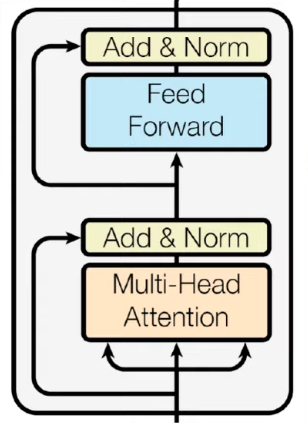
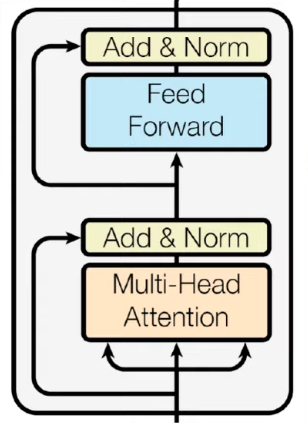

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, number_of_heads: int = 8, d_model: int = 512):
        """
        notes:
            - default parameter values are based on the paper
        """
        assert (
            d_model % number_of_heads == 0
        ), "d_model must be divisible by number_of_heads"
        super().__init__()
        self.multi_head_attention = MultiHead(h=number_of_heads, d_model=d_model)
        self.feed_forward = FeedForward(d_model=d_model)
        self.d_model = d_model
        self.layer_norms = torch.nn.ModuleList(
            torch.nn.LayerNorm(d_model) for _ in range(2)
        )

    def forward(
        self, x: torch.Tensor, pad_mask: torch.Tensor, dropout_p=None
    ) -> torch.Tensor:
        """
        input:
            x: a torch tensor of size: (batch_size, seq_len, d_model)
        output:
            a torch tensor of size: (batch_size, seq_len, d_model)
        """

        x = self.layer_norms[0](
            x
            + (
                self.multi_head_attention(x, x, x, pad_mask)
                if dropout_p is None
                else dropout(self.multi_head_attention(x, x, x, pad_mask), p=dropout_p)
            )
        )

        return self.layer_norms[1](
            x
            + (
                self.feed_forward(x)
                if dropout_p is None
                else dropout(self.feed_forward(x), p=dropout_p)
            )
        )


## Decoder Layer
Each Decoder layer consists of:

1. Masked Multi-Head Self-Attention (to ensure no future information is leaked)
2. Multi-Head Cross-Attention over the encoder outputs
3. Feed-Forward sub-layer
4. Residual connections and Layer Normalization around each sub-layer

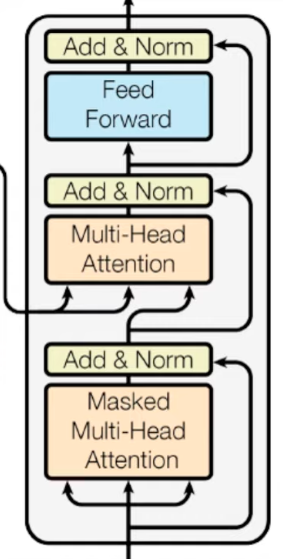
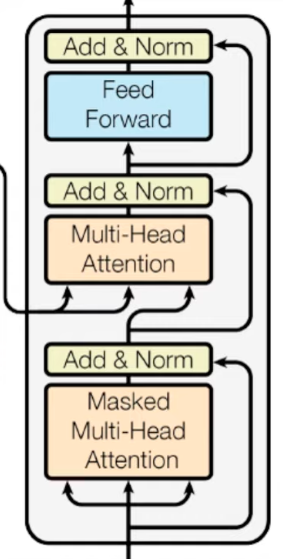

In [10]:
class Decoder(torch.nn.Module):
    def __init__(
        self,
        attention_mask: torch.Tensor,
        number_of_heads: int = 8,
        d_model: int = 512,
    ):
        """
        notes:
            - default parameter values are based on the paper
            - in the previous implementation we were using the same multi head
            module and inidicating the apply mask on the forward pass. That's an
            outregous mistake. The same parameters are being used in that case
            only when applying attention part of the sequence was getting masked.
        """
        assert (
            d_model % number_of_heads == 0
        ), "d_model must be divisible by number_of_heads"
        super().__init__()
        self.multi_head_attention = MultiHead(h=number_of_heads, d_model=d_model)
        self.masked_multi_head_attention = MultiHead(
            h=number_of_heads, d_model=d_model, mask=attention_mask
        )
        self.feed_forward = FeedForward(d_model=d_model)
        self.d_model = d_model
        self.layer_norms = torch.nn.ModuleList(
            torch.nn.LayerNorm(d_model) for _ in range(3)
        )

    def forward(
        self,
        x: torch.Tensor,
        encoder_x: torch.Tensor,
        decoder_pad_mask: torch.Tensor,
        encoder_pad_mask: torch.Tensor,
        dropout_p=None,
    ) -> torch.Tensor:
        """
        inputs:
            x: a torch tensor of size: (batch_size, seq_len, d_model)
            encoder_x: a torch tensor of size: (batch_size, seq_len, d_model)
        output:
            a torch tensor of size: (batch_size, seq_len, d_model)
        """
        x = self.layer_norms[0](
            x
            + (
                self.masked_multi_head_attention(x, x, x, decoder_pad_mask)
                if dropout_p is None
                else dropout(
                    self.masked_multi_head_attention(x, x, x, decoder_pad_mask),
                    p=dropout_p,
                )
            )
        )

        # Cross-Attention
        # Here encoder_pad_mask must be used because
        x = self.layer_norms[1](
            x
            + (
                self.multi_head_attention(x, encoder_x, encoder_x, encoder_pad_mask)
                if dropout_p is None
                else dropout(
                    self.multi_head_attention(
                        x, encoder_x, encoder_x, encoder_pad_mask
                    ),
                    p=dropout_p,
                )
            )
        )

        return self.layer_norms[2](
            x
            + (
                self.feed_forward(x)
                if dropout_p is None
                else dropout(self.feed_forward(x), p=dropout_p)
            )
        )

## Positional Encodings

The positional encoding $ PE_{(pos, i)} $ represents the position encoding at position $ pos $ in the sequence and hidden dimensionality $ i $. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization, see "Positional Encoding") to incorporate position information into the model.

The positional encoding is defined as:

$$
PE_{(pos, i)} =
\begin{cases} 
\sin\left(\frac{pos}{10000^{i / d_\text{model}}}\right) & \text{if } i \mod 2 = 0, \\
\cos\left(\frac{pos}{10000^{(i-1) / d_\text{model}}}\right) & \text{otherwise.}
\end{cases}
$$

### Intuition

1. **Even and Odd Dimensions**: The sine function is applied to even dimensions $(i \mod 2 = 0 )$, and the cosine function is applied to odd dimensions $ (i \mod 2 = 1) $ of the hidden state.
2. **Relative Position Encoding**: This encoding allows the model to attend to relative positions effectively. For example, $ PE_{(pos + k, :)} $ can be represented as a linear function of $ PE_{(pos, :)} $, enabling relative positional information.
3. **Wavelengths**: The wavelengths for different dimensions range from $ 2\pi $ to $ 10000 \cdot 2\pi $.

This design enables the Transformer model to capture the sequence's positional relationships without relying on recurrence or convolution.


In [11]:
def positional_encodings(seq_len: int, d_model: int) -> np.ndarray:
    pos, i = np.indices((seq_len, d_model))
    return np.where(
        i % 2 == 0,
        np.sin(pos / np.power(10000, (2 * i / d_model))),
        np.cos(pos / np.power(10000, (2 * i / d_model))),
    )

## Attention Masks
### Causal Mask (for Decoder):
We create a lower-triangular matrix where positions in the future are masked with `-inf`.

### Padding Mask:
We mask out padding tokens in inputs so that the model does not attend to them.

In [12]:
def get_attention_mask(seq_len: int, dtype: torch.dtype) -> torch.Tensor:
    """
    Here we will be creating a triangular matrix where
    all the upper triangle (above the diagonal) is set to -oo.

    output:
        A torch tensor of size: (seq_len, seq_len)
    """

    mask_x = torch.full((seq_len, seq_len), float("-inf"), dtype=dtype)

    return torch.triu(mask_x, diagonal=1)

    # Add a new batch_size dimension and expand it to
    # match batch_size
    # -1 means keep the size at that dimension
    # However its also documented here:
    # https://stackoverflow.com/questions/65900110/does-pytorch-broadcast-consume-less-memory-than-expand
    # that expand does not also consume extra memory
    # mask = mask.unsqueeze(0).expand(batch_size, -1, -1)


def get_pad_mask(
    x: torch.Tensor, h: int, batch_size: int, seq_len: int, pad_token_id: int = 0
) -> torch.Tensor:
    """
    inputs:
        x: a torch tensor of size: (batch_size, seq_len)
    """
    # 0 must be the padding token id
    # Here torch.where(encoder_x == 0, float("-inf"), 0)
    #    .unsqueeze(2)
    #    .expand(-1, -1, self.seq-len)
    # should also mathematically produce the same shape
    # but typically the keys gets masked so the current approach
    # aligns better with the paper
    assert x.size() == (
        batch_size,
        seq_len,
    ), f"x must have size: {(batch_size, seq_len)}"

    return (
        torch.where(x == pad_token_id, float("-inf"), 0)
        .unsqueeze(1)
        .unsqueeze(1)
        .expand(-1, h, seq_len, -1)
        .reshape(batch_size * h, seq_len, seq_len)
    )


## The Transformer

In [13]:
class Transformer(torch.nn.Module):
    def __init__(
        self,
        batch_size: int,
        seq_len: int,
        d_model: int = 512,
        n: int = 6,
        number_of_heads: int = 8,
        input_vocab_size: int = 37000,
        output_vocab_size: int = 37000,
        dtype: torch.dtype = torch.float32,
        dropout_p: float = None,
    ):
        """
        inputs:
            n: the number of encoder and decoder stacks
            d_model: model dimensions, i.e. embedding dimensions
            number_of_heads: number of heads using in multi-head attention
            input_vocab_size: size of the vocabulary for the input structure
            output_vocab_size: size of the vocabulary for the output structure

        notes:
            - I'm using a fixed seq_len for both the input and the output. That could
            be adjusted to make it varied and more flexible.

        """
        super().__init__()
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.n = n
        self.d_model = d_model
        self.number_of_heads = number_of_heads
        self.vocab_size = output_vocab_size
        self.dtype = dtype
        self.register_buffer(
            "pe",
            torch.from_numpy(positional_encodings(seq_len, d_model))
            .to(dtype)
            .unsqueeze(0),
        )
        self.register_buffer("attention_mask", get_attention_mask(seq_len, dtype=dtype))
        self.linear = torch.nn.Linear(d_model, output_vocab_size)
        assert (
            dropout_p is None or 0 <= dropout_p <= 1
        ), "p_dropout must be a value between 0 and 1"
        self.dropout_p = dropout_p

        self.input_embedding = torch.nn.Embedding(
            num_embeddings=input_vocab_size, embedding_dim=d_model
        )
        self.output_embedding = torch.nn.Embedding(
            num_embeddings=output_vocab_size, embedding_dim=d_model
        )

        # Using ModuleList is crucial here instead of python list
        # If python list is used, then model.parameters() will not
        # return the paremeters of layers inside.
        self.encoders = torch.nn.ModuleList(
            Encoder(number_of_heads=number_of_heads, d_model=d_model)
            for _ in range(self.n)
        )

        self.decoders = torch.nn.ModuleList(
            Decoder(
                attention_mask=self.attention_mask,
                number_of_heads=number_of_heads,
                d_model=d_model,
            )
            for _ in range(self.n)
        )

    def forward(
        self,
        encoder_x: torch.Tensor,
        decoder_x: torch.Tensor,
        apply_softmax: bool = False,
        pad_token_id: int = 0,
    ):
        """
        inputs:
            encoder_x: a torch tensor of size: (batch_size, seq_len)
            decoder_x: a torch tensor of size: (batch_size, seq_len)
            apply_softmax: a boolean.
                - Most torch loss functions expect logits instead of porbabilities.
                So make sure that the loss function does not normalize inputs and
                expects probabilities before setting this to True.

        outputs:
            a probability distribution over the vocabulary
        """
        assert (
            encoder_x.size() == decoder_x.size() == (self.batch_size, self.seq_len)
        ), f"encoder_x and decoder_x must both have the size: ({self.batch_size}, {self.seq_len})"

        assert torch.any(encoder_x) and torch.any(decoder_x), (
            "empty examples are not allowed. There could be some additional reasons "
            "for not to allow them but simple example why is that softmax is not defined "
            "over an empty sequence"
        )

        encoder_x_pad_mask = get_pad_mask(
            encoder_x,
            h=self.number_of_heads,
            batch_size=self.batch_size,
            seq_len=self.seq_len,
            pad_token_id=pad_token_id,
        )
        decoder_x_pad_mask = get_pad_mask(
            decoder_x,
            h=self.number_of_heads,
            batch_size=self.batch_size,
            seq_len=self.seq_len,
            pad_token_id=pad_token_id,
        )

        # In the paper it is mentioned that they scale the embedding weights by math.sqrt(self.d_model)
        # see the end of section 3.4 for more detail
        encoder_x = self.input_embedding(encoder_x) * math.sqrt(self.d_model) + self.pe
        decoder_x = self.output_embedding(decoder_x) * math.sqrt(self.d_model) + self.pe

        for encoder in self.encoders:
            encoder_x = encoder(encoder_x, encoder_x_pad_mask, dropout_p=self.dropout_p)

        for decoder in self.decoders:
            decoder_x = decoder(
                decoder_x,
                encoder_x,
                decoder_pad_mask=decoder_x_pad_mask,
                encoder_pad_mask=encoder_x_pad_mask,
                dropout_p=self.dropout_p,
            )

        return (
            softmax(self.linear(decoder_x), d=2)
            if apply_softmax
            else self.linear(decoder_x)
        )

## Testing on the counting dataset

In [14]:
import torch
import numpy as np
from torch.utils.data import DataLoader

# Use the CountingDataset
class CountingDataset(torch.utils.data.Dataset):
    def __init__(self, n, max_length=8, vocab_size=3):
        assert vocab_size > 2
        self.n = n
        self.vocab_size = vocab_size
        seq_lengths = np.random.randint(max_length // 2, max_length, n)
        data = np.random.randint(1, vocab_size, (n, max_length))

        # Replace elements past the sequence length with 0 (padding token)
        for i in range(n):
            data[i, seq_lengths[i]:] = 0

        # Labels: whether `1`s outnumber `2`s
        num_ones = (data == 1).sum(axis=1)
        num_twos = (data == 2).sum(axis=1)
        self.data = torch.tensor(data, dtype=torch.long)
        self.labels = torch.tensor((num_ones > num_twos).astype(int), dtype=torch.long)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Create dataset and dataloader
dataset = CountingDataset(1000, max_length=8, vocab_size=3)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

# Transformer Model Parameters
batch_size = 32
seq_len = 8
d_model = 16
number_of_heads = 2
n = 2
input_vocab_size = 3  # Matches CountingDataset
output_vocab_size = 2  # Binary classification (0 or 1)

# Instantiate Transformer Model
model = Transformer(
    batch_size=batch_size,
    seq_len=seq_len,
    d_model=d_model,
    n=n,
    number_of_heads=number_of_heads,
    input_vocab_size=input_vocab_size,
    output_vocab_size=output_vocab_size,
)

# Define Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 120
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        # Initialize decoder input with start-of-sequence tokens
        decoder_x = torch.zeros_like(x)
        decoder_x[:, 0] = 1  # Start-of-sequence token

        # Forward pass
        output = model(x, decoder_x)

        # Use output at the last position for classification
        logits = output[:, -1, :]  # Shape: (batch_size, output_vocab_size)
        loss = criterion(logits, y)

        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

# Testing the Model
model.eval()
with torch.no_grad():
    for test_data, test_labels in dataloader:
        if test_data.size(0) != batch_size:
            continue

        decoder_x = torch.zeros_like(test_data)
        decoder_x[:, 0] = 1  # Start-of-sequence token
        output = model(test_data, decoder_x, apply_softmax=True)
        predictions = torch.argmax(output[:, -1, :], dim=-1)

        print("Test Labels:", test_labels.numpy())
        print("Predictions:", predictions.numpy())
        break


Epoch 1/120, Loss: 0.39936153302269595
Epoch 2/120, Loss: 0.05192622422210632
Epoch 3/120, Loss: 0.02949662596708344
Epoch 4/120, Loss: 0.01975400421407915
Epoch 5/120, Loss: 0.014162958779883
Epoch 6/120, Loss: 0.010661602290647646
Epoch 7/120, Loss: 0.008314707016031589
Epoch 8/120, Loss: 0.006653570840435643
Epoch 9/120, Loss: 0.005445624821849408
Epoch 10/120, Loss: 0.004529343662603247
Epoch 11/120, Loss: 0.0038199807637401165
Epoch 12/120, Loss: 0.003260170823083289
Epoch 13/120, Loss: 0.0028117851564480414
Epoch 14/120, Loss: 0.0024440342920922465
Epoch 15/120, Loss: 0.0021412877005434804
Epoch 16/120, Loss: 0.0018849975632263287
Epoch 17/120, Loss: 0.0016680228779272688
Epoch 18/120, Loss: 0.001482616377724034
Epoch 19/120, Loss: 0.0013232209922505482
Epoch 20/120, Loss: 0.0011851431186040563
Epoch 21/120, Loss: 0.0010657800838441377
Epoch 22/120, Loss: 0.0009593945428458673
Epoch 23/120, Loss: 0.0008659068280981193
Epoch 24/120, Loss: 0.0007825805035780274
Epoch 25/120, Loss: 